<a href="https://colab.research.google.com/github/RMichae1/PyroStudies/blob/master/changepoint_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pyro
import pyro.distributions as dist
from pyro.distributions import constraints
from pyro.infer import NUTS, MCMC
from pyro.optim import Adam
import pandas as pd
import torch
from tqdm import tqdm
import us
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
import numpy as np

In [ ]:
# prepared and pivoted dataset
suicide_data = pd.read_csv("./suicide_deaths_by_age.csv")
suicide_data

,Year,Age,Suicides
0,1981,10,0
1,1981,11,0
2,1981,12,2
3,1981,13,2
4,1981,14,1
...,...,...,...
2955,2017,85,18
2956,2017,86,23
2957,2017,87,14
2958,2017,88,17


In [ ]:
# lets look at a specific agegroup for the years 1981 to 2017:
suicide_millenials_df = suicide_data[suicide_data.Age.isin(range(23,35))].groupby(["Year"]).mean().reset_index()
suicide_millenials_df["Suicides"] = suicide_millenials_df.Suicides.round()
suicide_millenials_df.head()

,Year,Age,Suicides
0,1981,28.5,85.0
1,1982,28.5,83.0
2,1983,28.5,75.0
3,1984,28.5,78.0
4,1985,28.5,86.0


In [ ]:
years = torch.from_numpy(suicide_millenials_df.Year.values)
suicides = torch.from_numpy(suicide_millenials_df.Suicides.values)
data_len = len(suicide_millenials_df)

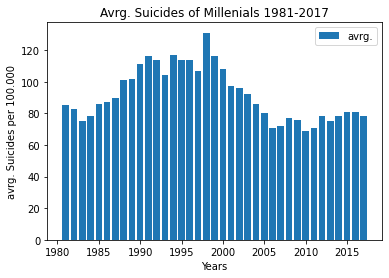

In [ ]:
plt.bar(years, suicides, label="avrg.")
plt.title("Avrg. Suicides of Millenials 1981-2017")
plt.xlabel("Years")
plt.ylabel("avrg. Suicides per 100.000")
plt.legend()
plt.savefig("./avrg_suicide_data.png")

In [ ]:
def model(years, suicides):
    σ = pyro.param('σ', torch.ones(data_len))
    # Independent events 
    T = pyro.sample('change', dist.Uniform(1981, 2017))
    grp = (years > T) * 1
    with pyro.plate('rate', 2):
        μ = pyro.sample('μ', dist.HalfNormal(scale=50))
    y_obs = pyro.sample('obs', dist.Normal(μ[grp], σ), obs=suicides)

In [ ]:
SAMPLES = 1000
WARMUP = 300

In [ ]:
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=SAMPLES, warmup_steps=WARMUP)
mcmc.run(years, suicides)

Sample: 100%|██████████| 1300/1300 [09:54,  2.19it/s, step size=1.98e-03, acc. prob=0.912]


In [ ]:
samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}
mcmc.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    change   1995.40      2.10   1995.40   1991.72   1998.24      3.04      1.94
      μ[0]     96.21     10.41     97.56     93.81    101.23     20.16      1.08
      μ[1]     87.62      2.59     87.90     83.01     90.94      3.03      1.95

Number of divergences: 0


In [ ]:
samples['change']

array([1991.724 , 1991.7227, 1991.7242, 1991.7258, 1991.7253, 1991.7233,
       1991.7217, 1991.722 , 1991.7155, 1991.7194, 1991.7206, 1991.7205,
       1991.7277, 1991.7284, 1991.721 , 1991.7167, 1991.8597, 1991.8586,
       1991.853 , 1991.8531, 1991.8126, 1991.7311, 1991.7307, 1991.7723,
       1991.7723, 1991.2715, 1991.6108, 1991.6099, 1991.9117, 1991.7256,
       1991.7258, 1991.7264, 1991.7273, 1991.727 , 1991.7273, 1991.727 ,
       1991.7245, 1991.7245, 1991.4622, 1991.2363, 1991.2358, 1991.582 ,
       1991.6311, 1991.6311, 1991.6334, 1991.6344, 1991.6344, 1991.6344,
       1991.6344, 1991.6339, 1991.6312, 1991.6306, 1991.6294, 1991.4073,
       1991.4064, 1991.4064, 1991.3562, 1991.3563, 1991.3553, 1991.3512,
       1991.3492, 1991.3502, 1991.9149, 1991.9166, 1991.9452, 1991.9447,
       1991.9446, 1991.9194, 1991.833 , 1991.7626, 1991.762 , 1992.0017,
       1992.001 , 1992.0006, 1992.    , 1992.0076, 1992.0059, 1992.0211,
       1992.0211, 1992.0084, 1992.0021, 1992.0013, 

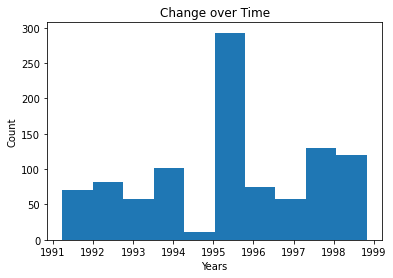

In [ ]:
plt.hist(samples['change'])
plt.title("Change over Time")
plt.xlabel("Years")
plt.ylabel("Count")
plt.savefig("./hist_change.png")

In [ ]:
df = pd.DataFrame() 
df['change'] = samples['change']
df['rate0'] = samples['μ'][..., 0]
df['rate1'] = samples['μ'][..., 1]

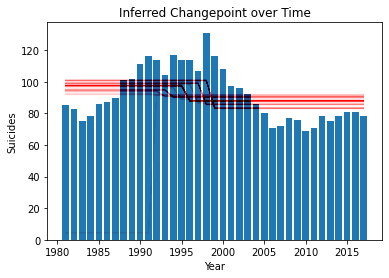

In [ ]:
plt.bar(years, suicides, label='avrg.')
plt.xlabel('Year')
plt.ylabel('Suicides')
plt.title('Inferred Changepoint over Time')

def pl(pt):
    grp = (years > pt['change']) * 1
    line = plt.plot(years, pt['rate0'] * (1 - grp) + pt['rate1'] * grp, 
      color='red', alpha=0.005)    

    
df.apply(pl, axis=1)
plt.savefig("./changepoint_rate_suicides.png")
plt.show()